# Criando mapas e visualizando dados geográficos

Voltar ao [índice](../00_indice.ipynb)

Este _notebook_ faz parte da 
[análise da idade média ao morrer](10_analise_idade_med-obitos_distritos_municipio-SP.ipynb) 
nos diferentes distritos do município de São Paulo. 

**Objetivos** 

Visualizar a idade média ao morrer em cada distrito da cidade de São Paulo em um mapa.

**Você vai aprender:**
* Sobre arquivos que armazenam dados geoespaciais, como o [_shapefile_](https://ceweb.br/guias/dados-abertos/capitulo-41/).
* Como carregar esses dados, utilizando o pacote [geopandas](https://geopandas.org/en/stable/).
* Como adicionar informação aos mapas.
* Como visualizar as informações. 

In [2]:
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as pl
import sys
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Carrega código auxiliar no tutorial:
sys.path.append("../80_material-complementar/")
import auxiliar.texto as at
import auxiliar.geo as ag
import auxiliar.zip as az

## 1. Carregando os dados

### 1.1. Fronteiras dos distritos da cidade de São Paulo

Mapas e dados georreferenciados do município de São Paulo podem ser obtidos aqui:
<http://geosampa.prefeitura.sp.gov.br>. 

<https://geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadArquivo.aspx?orig=DownloadCamadas&arq=01_Limites%20Administrativos%5C%5CDistrito%5C%5CShapefile%5C%5CSIRGAS_SHP_distrito&arqTipo=Shapefile>

In [3]:
# Baixa mapas:
url_fonte = 'https://nucleodetecnologia.com.br/dados/SIRGAS_SHP_distrito.zip'
az.sincronizar_arquivos(url_fonte, '../90_dados/', ['SIRGAS_SHP_distrito'])

# Carrega informações geoespaciais dos distritos (fronteiras):
distritos_gdf = gp.read_file('../90_dados/SIRGAS_SHP_distrito/SIRGAS_SHP_distrito.shp')
# Exibe algumas linhas:
distritos_gdf.head()

Arquivos já foram baixados


,ds_codigo,ds_nome,ds_sigla,ds_cd_sub,ds_subpref,ds_areamt,ds_areakmt,geometry
0,51,MANDAQUI,MAN,05,SANTANA-TUCURUVI,1.324786e+07,13.25,"POLYGON ((330950.373 7407837.176, 330952.177 7..."
1,52,MARSILAC,MAR,20,PARELHEIROS,2.081957e+08,208.20,"POLYGON ((336124.090 7355302.282, 336121.755 7..."
2,32,MOEMA,MOE,12,VILA MARIANA,9.079516e+06,9.08,"POLYGON ((331242.174 7392162.324, 331244.581 7..."
3,31,GUAIANASES,GUA,28,GUAIANASES,8.938527e+06,8.94,"POLYGON ((355108.237 7393291.184, 355107.277 7..."
4,33,IGUATEMI,IGU,30,SAO MATEUS,1.958356e+07,19.58,"POLYGON ((350859.949 7389599.855, 350880.182 7..."


### 1.2. Idade média ao morrer

Vamos carregar a idade média ao morrer que foi calculada no notebook [10_analise_idade_med-obitos_distritos_municipio-SP.ipynb](10_analise_idade_med-obitos_distritos_municipio-SP.ipynb):

In [4]:
# Carrega a expectativa de vida por distrito:
exp_vida_df = pd.read_csv('dados/processados/expectativa-de-vida_distritos-SP.csv')
# Adiciona coluna com nomes iguais aos do mapa, para poder juntar:
exp_vida_df['chave'] = exp_vida_df['distrito'].str.upper().apply(at.remove_acentos)
# Exibe algumas linhas:
exp_vida_df.head()

,distrito,exp_vida_anos,chave
0,Cidade Tiradentes,55.151054,CIDADE TIRADENTES
1,Jardim Ângela,55.486721,JARDIM ANGELA
2,Anhanguera,55.576645,ANHANGUERA
3,Iguatemi,56.504711,IGUATEMI
4,Grajaú,56.624504,GRAJAU


### 1.3. Juntando as duas bases

Vamos juntar a informação sobre a idade média ao morrer ao mapa dos distritos do município de São Paulo:

In [7]:
# Junta a expectativa de vida aos dados geoespaciais:
exp_vida_gdf = distritos_gdf.join(exp_vida_df.set_index('chave'), on='ds_nome')

# Cria legenda (nome do distrito + expectativa de vida) para o mapa:
exp_vida_gdf['legenda'] = exp_vida_gdf['distrito'] + '\n' + exp_vida_gdf['exp_vida_anos'].round(0).astype(int).astype(str)

## 2. Visualizando os dados

Abaixo criamos uma visualização do mapa, com a idade média ao morrer representada por uma escala de cor. A escala escolhida vai de vermelho (expectativa mais baixa) a azul (expectativa mais alta).

Para criar um mapa a partir de um DataFrame do geopandas (chamado de GeoDataFrame), basta chamar seu método `.plot()`. Esse método vai utilizar a coluna `geometry`, que contém as informações geográficas, e utilizá-la para criar o mapa. No caso em questão, ele vai desenhar as fronteiras dos distritos do município.

Para que os valores de alguma coluna sejam representados por uma escala de cor no mapa, basta especificar a coluna de interesse. No nosso caso, utilizamos o código `exp_vida_pdf.plot(column='exp_vida_anos')`. O parâmetro `legend=True` providencia uma escala de cor de referência. Você também pode escolher uma escala de cor diferente através do parâmetro `cmap`: basta definí-lo como uma das 
[opções disponíveis](https://matplotlib.org/stable/tutorials/colors/colormaps.html#sequential) (você pode acrescentar um `'_r'` ao final do nome da escala para invertê-la).

O parâmetro `alpha` é a opacidade (contrário de transparência) do mapa. Ela vai de 0 (completamente transparente) a 1 (completamente opaco). Já o parâmetro `ax` pode ser usado para especificar a qual eixo (_axes_) o mapa deve ser adicionado. Isso é útil quando queremos adicionar várias informações geográficas a uma mesma visualização. E o parâmetro `cax` especifica onde colocar a legenda.

A função `ag.legenda_no_mapa()`, que criamos e colocamos no arquivo [../80_material-complementar/auxiliar/geo.py](../80_material-complementar/auxiliar/geo.py), utiliza o método `.representative_point()` do GeoDataFrame para encontrar pontos mais ou menos no centro dos distritos, e escreve o conteúdo da coluna 'legenda' da `exp_vida_gdf` nesses pontos. Essa coluna 'legenda' contém o nome do distrito e sua idade média ao morrer em anos.

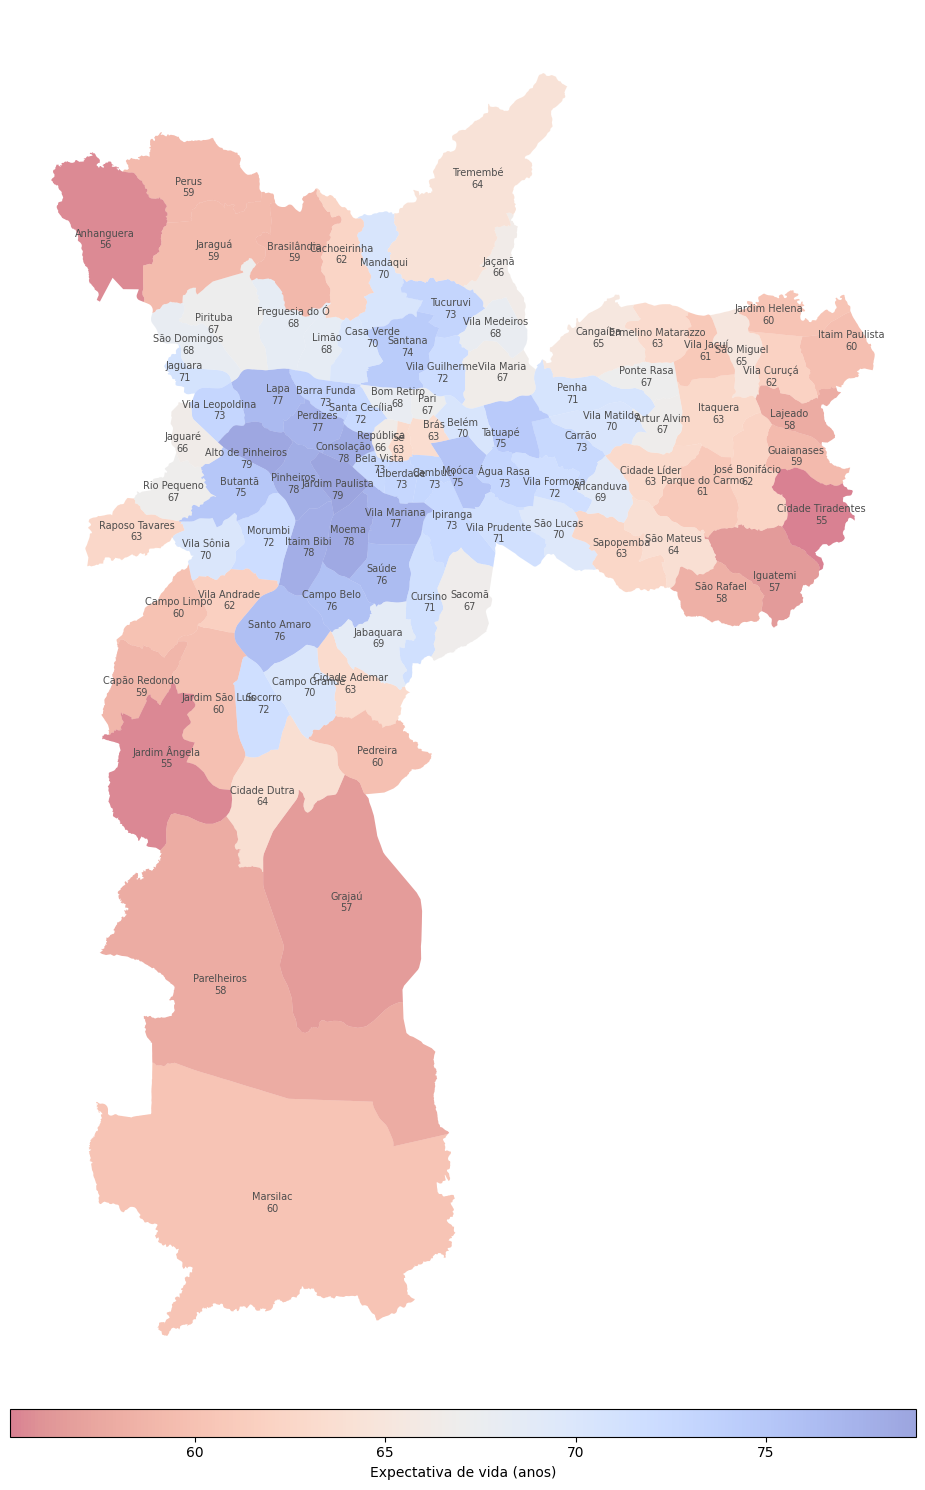

In [8]:
# Cria figura:
fig, ax = pl.subplots(1,1, figsize=(15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="2%", pad=0.1)
fig.set_facecolor('white')

# Cria o mapa com escala de cor para a idade média ao morrer:
exp_vida_gdf.plot(column='exp_vida_anos', ax=ax, alpha=0.5, legend=True, cmap='coolwarm_r', cax=cax, 
                   legend_kwds={'label': 'Expectativa de vida (anos)', 'orientation': 'horizontal', 'alpha': 0.5})

# Adiciona legenda aos distritos (nome e idade média ao morrer):
ag.legenda_no_mapa(exp_vida_gdf, 'legenda', 3e2, ax=ax, fontsize=7, color='0.3')

# Finaliza:
ax.axis('off')
pl.tight_layout()
pl.show()

### 2.1. Interpretando o mapa

O centro do município de São Paulo fica ao redor do distrito da Sé, e inclui a República e o Brás. O que está à esquerda do centro no mapa é chamado de zona oeste, e é uma das regiões mais ricas da cidade. Vemos no mapa que é essa a região com as maiores idades médias ao morrer, chegando a quase 80 anos. Um grande padrão que se observa no mapa é a queda gradativa e sistemática dessa idade à medida que nos direcionamos às periferias da cidade. 

Esse padrão de mudança mostra que a violência e a precariedade da saúde não de distribuem de maneira aleatória. Isto é: não são peculiaridades ou acasos que diferenciam os distritos, mas sim uma estrutura social que privilegia alguns distritos e negligencia outros. 

Com exceção do centro de São Paulo, degradado tal qual em outras cidades brasileiras e latinoamericanas, a grande escala do padrão observado (isto é, uma única grande região de maior idade média ao morrer agrupada na região central, com as regiões de baixa idade média ao morrer localizadas apenas nas periferias) evidencia a segregação social existente no município. A distância entre o Jardim Paulista - um dos distritos com maior expectativa de vida - e o Jardim Ângela, na zona sul, é de cerca de 20km. A diferença na idade média ao morrer entre esses dois distritos é de 24 anos.

### 2.2. Versão do mapa para divulgação

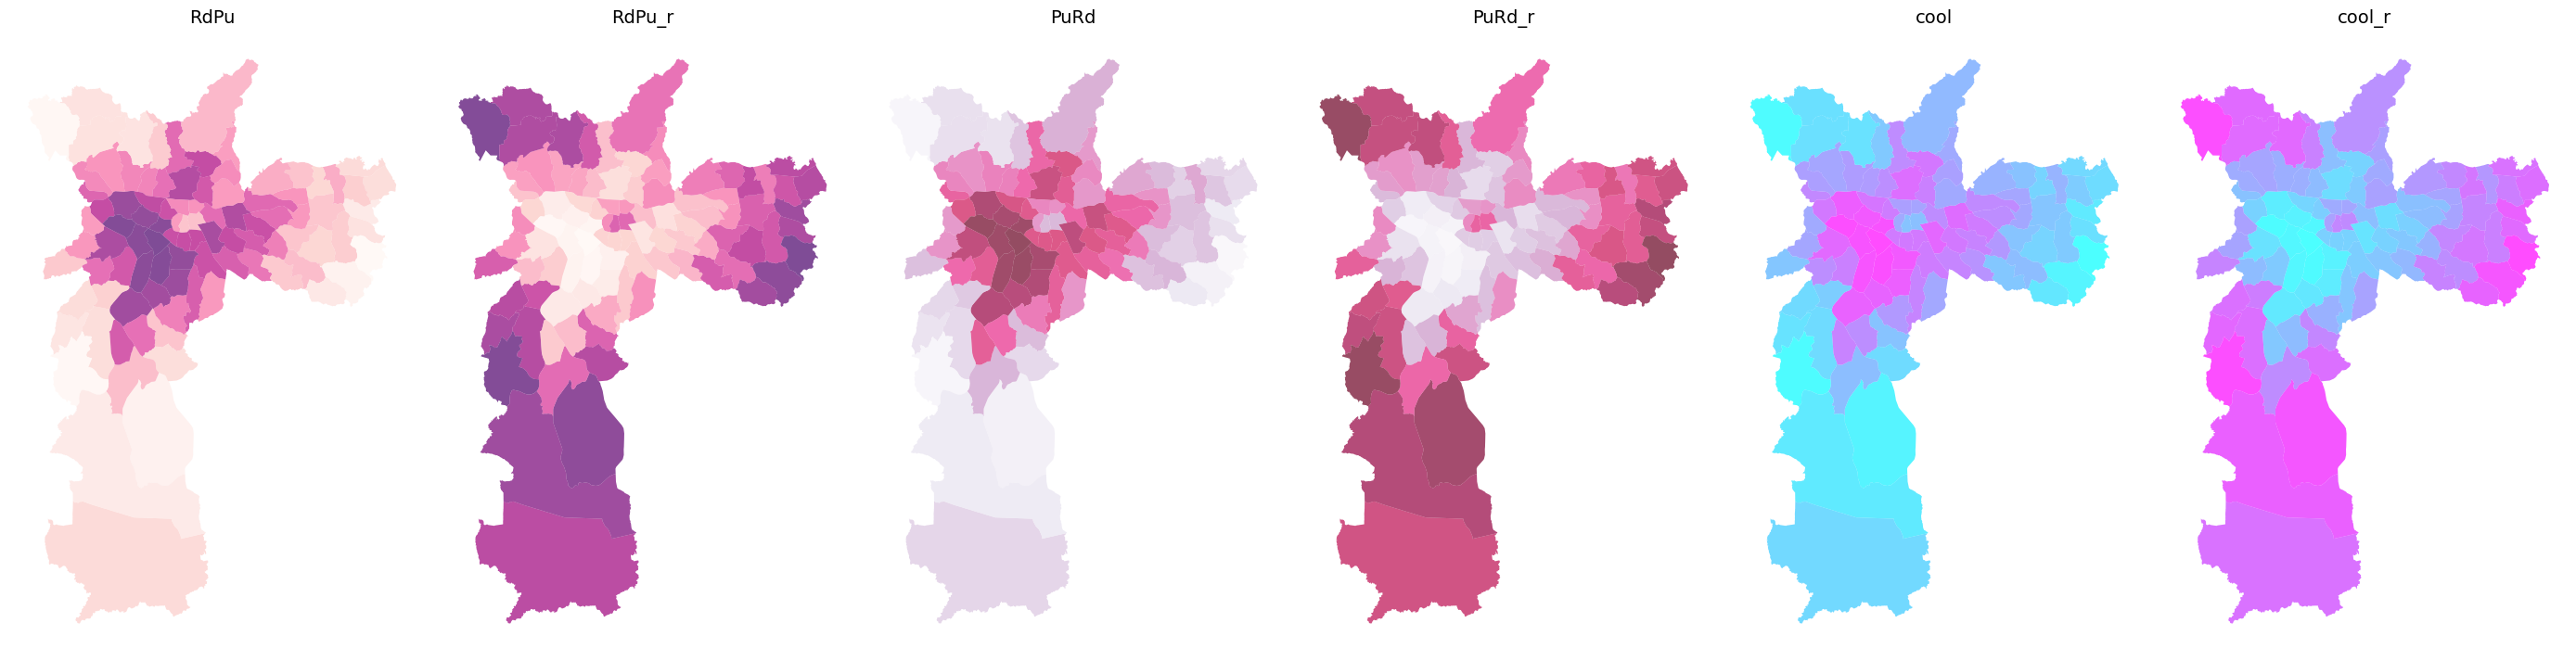

In [9]:
# Cria figura:
fig = pl.figure(figsize=(28,7))
fig.set_facecolor('white')

# Cria o mapa com escala de cor para a idade média ao morrer:
scales = ['RdPu', 'RdPu_r', 'PuRd', 'PuRd_r', 'cool', 'cool_r']
for i, c in enumerate(scales):
    pl.subplot(1, 6, i + 1)
    ax = pl.gca()
    exp_vida_gdf.plot(column='exp_vida_anos', ax=ax, alpha=0.7, legend=False, cmap=c)
    pl.title(c, fontsize=14)
    # Finaliza:
    ax.axis('off')
pl.tight_layout()
pl.show()

<center>
    <img src="https://nucleodetecnologia.com.br/assets/img/novo-logo-tecnologia.svg?bl=tutorial-exp-vida-17" width="150">
</center>